# Chapter 8. Dimesionality Reduction

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## PCA

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## Principal Components

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

## Projecting Down to d Dimensions

In [4]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [5]:
X2D_using_svd = X2D

## Using Scikit-Learn

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [7]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

## Explained Varaince Ratio

In [12]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

##  Choosing the Right Number of Dimensions

In [15]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame=False)
mnist.target= mnist.target.astype(np.uint8)

In [16]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [19]:
d

154

In [21]:
pca = PCA(n_components=0.95)
X_reduced =pca.fit(X_train)

In [22]:
pca.n_components_

154

In [23]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557436

## PCA for Compression

In [24]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

## Randomized PCA

In [25]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

In [27]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca =IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [30]:
filename = "my_mnist.data"
m, n = X_train.shape
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components,batch_size=batch_size)
inc_pca.fit(X_mm)

FileNotFoundError: [Errno 2] No such file or directory: 'my_mnist.data'

## Kernel PCA

In [13]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll
#from sklearn.datasets import fetch_openml

# mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# X = mnist["data"]
# y = mnist["target"]

X, t= make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

### Selecting Kernel and Tuning Hyperparameters

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

param_grid = ({
    "kpca__gamma": np.linspace(0.03,0.05),
    "kpca__kernel": ["rbf","sigmoid"]
})

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'kpca__gamma': array([0.03      , 0.03040816, 0.03081633, 0.03122449, 0.03163265,
       0.03204082, 0.03244898, 0.03285714, 0.03326531, 0.03367347,
       0.03408163, 0.0344898 , 0.03489796, 0.03530612, 0.03571429,
       0.03612245, 0.03653061, 0.03693878, 0.03734694, 0...
       0.03816327, 0.03857143, 0.03897959, 0.03938776, 0.03979592,
       0.04020408, 0.04061224, 0.04102041, 0.04142857, 0.04183673,
       0.0422449 , 0.04265306, 0.04306122, 0.04346939, 0.04387755,
       0.04428571, 0.04469388, 0.04510204, 0.0455102 , 0.04591837,
       0.04632653, 0.04673469, 0.04714286, 0.04755102, 0.04795918,
       0.04836735, 0.04877551, 0.04918367, 0.04959184, 0.05      ]),
                         'kpca__kernel': ['rbf', 'sigmoid']})

In [15]:
grid_search.best_params_

{'kpca__gamma': 0.04469387755102041, 'kpca__kernel': 'rbf'}

In [18]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04469,fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)


In [20]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

33.147455813464106

## LLE

In [1]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=100, noise=0.2, random_state=42)

In [2]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced= lle.fit_transform(X)

## Exercise solutions

### 9.

In [14]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784',version=1,as_frame=False)
X = mnist["data"]
y = mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 60000, test_size=10000)

In [18]:
from sklearn.ensemble import RandomForestClassifier
import time

rfc = RandomForestClassifier( random_state=42)
start = time.time()
rfc.fit(X_train, y_train)
end = time.time()
print(end-start)

32.24467468261719


In [36]:
from sklearn.metrics import accuracy_score
y_pred =rfc.predict(X_test)
accuracy_score(y_test, y_pred )

0.9685

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
reduced_X = pca.fit_transform(X_train)

In [26]:
pca.n_components_

153

In [38]:
rfc2 = RandomForestClassifier(random_state=42)
reduced_X_test = pca.transform(X_test)
start2 = time.time()
rfc2.fit(reduced_X, y_train)
end2 = time.time()
print(end2-start2)

77.7782654762268


In [39]:
y_pred2 = rfc2.predict(reduced_X_test)
accuracy_score(y_test, y_pred2)

0.6365

### 10.

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1, as_frame=False)

np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]
X = mnist["data"][idx]
y = mnist["target"][idx]

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

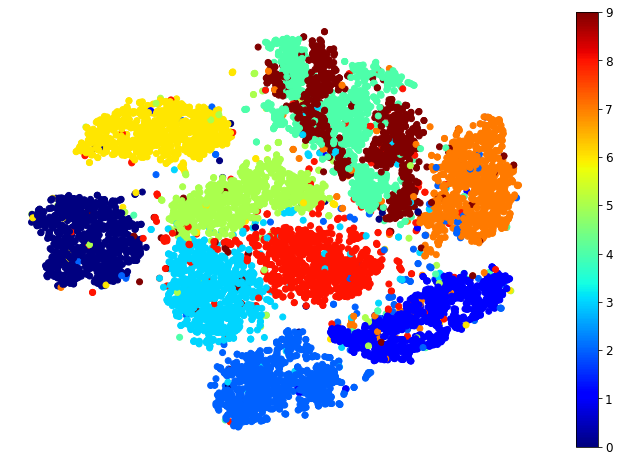

In [43]:
plt.figure(figsize=(12,8))
y_int = [int(i) for i in y]
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_int, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components =2 , random_state=42)
X_reduced = pca.fit_transform(X)

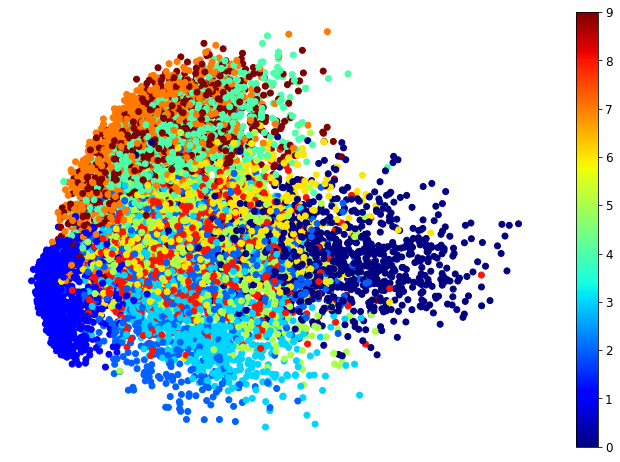

In [48]:
plt.figure(figsize=(12,8))
y_int = [int(i) for i in y]
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_int, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

In [56]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_reduced = lle.fit_transform(X)
y = mnist["target"]

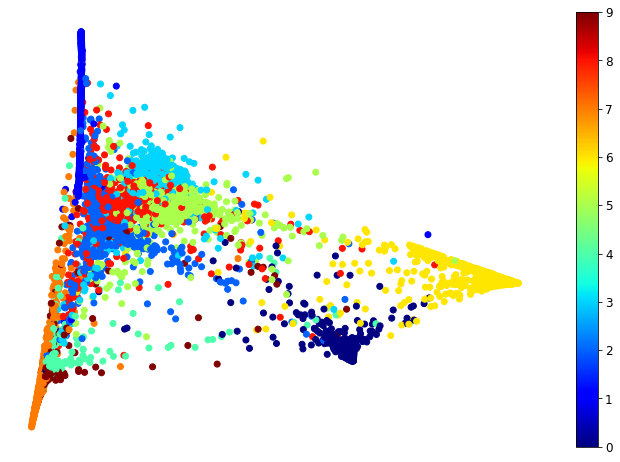

In [57]:
plt.figure(figsize=(12,8))
y_int2 = [int(i) for i in y]
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y_int2, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
from sklearn.manifold import MDS

m =2000
mds = MDS(n_components=2, random_state=42)
X_reduced = mds.fit_transform(X[:m])

In [ ]:
y = mnist["target"][:m]
y_int3 = [int(i) for i in y]

plt.figure(figsize=(12,8))
plt.scatter(X_reduced[:,0], X_reduced[:,1],c=y_int3, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()